In [21]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import mlflow
import xgboost as xgb

In [2]:

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-very-new-exp')

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-very-new-exp', tags={}>

In [3]:
df = pd.read_parquet('../datasets/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [4]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.838799799829477

/home/kan/.conda/envs/mlenv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/kan/.conda/envs/mlenv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


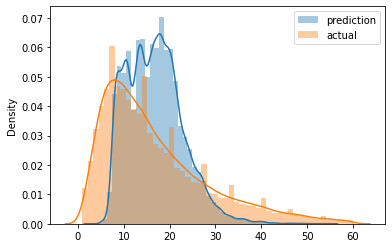

In [5]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [6]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('../datasets/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../datasets/green_tripdata_2021-02.parquet')

In [8]:
len(df_train), len(df_val)

(73908, 61921)

In [9]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715204112563

In [13]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [19]:
with mlflow.start_run():
    mlflow.set_tag('developer', 'okan')
    mlflow.log_param("train-data-path", '../datasets/green_tripdata_2021-01.parquet')
    mlflow.log_param('valid-data-path', '../datasets/green_tripdata_2021-02.parquet')
    
    alpha = 0.1
    mlflow.log_param('alpha', alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)
    
    mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path='models_pickle')

In [23]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [24]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [35]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric('rmse', rmse)
    
    return {'loss': rmse, 'status': STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,    
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

In [ ]:
params = {
    'learning_rate':	0.15424816063671712,
    'max_depth':	37,
    'min_child_weight':	1.3306496179849947,
    'objective':	'reg:linear',
    'reg_alpha':	0.011110038270279525,
    'reg_lambda':	0.34427155608549026,
    'seed':	42
}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )

In [26]:
mlflow.xgboost.autolog(disable=True)

In [27]:
with mlflow.start_run():
    
    best_params = {
    'learning_rate':	0.15424816063671712,
    'max_depth':	37,
    'min_child_weight':	1.3306496179849947,
    'objective':	'reg:linear',
    'reg_alpha':	0.011110038270279525,
    'reg_lambda':	0.34427155608549026,
    'seed':	42
    }
    
    mlflow.log_params(best_params)
    
    booster = xgb.train(
            params=best_params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
            )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)
    
    with open('models/preprocessor.b', 'wb') as f_out:
            pickle.dump(dv, f_out)
    
    mlflow.log_artifact('models/preprocessor.b', artifact_path='preprocessor')
    
    mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

[11:47:50] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:18.44134
[1]	validation-rmse:16.15868
[2]	validation-rmse:14.27377
[3]	validation-rmse:12.72838
[4]	validation-rmse:11.46965
[5]	validation-rmse:10.45471
[6]	validation-rmse:9.63749
[7]	validation-rmse:8.98718
[8]	validation-rmse:8.47063
[9]	validation-rmse:8.05949
[10]	validation-rmse:7.73731
[11]	validation-rmse:7.48177
[12]	validation-rmse:7.28122
[13]	validation-rmse:7.12271
[14]	validation-rmse:6.99760
[15]	validation-rmse:6.89845
[16]	validation-rmse:6.81979
[17]	validation-rmse:6.75458
[18]	validation-rmse:6.70179
[19]	validation-rmse:6.65982
[20]	validation-rmse:6.62498
[21]	validation-rmse:6.59539
[22]	validation-rmse:6.57101
[23]	validation-rmse:6.55164
[24]	validation-rmse:6.53549
[25]	validation-rmse:6.52205
[26]	validation-rmse:6.51017
[27]	validation-rmse:6.50007
[28]	validation-rmse:6.49232
[29]	validation-rmse:6.48593
[30]	validation

In [28]:
logged_model = 'runs:/2761b9a1f43c4f549c6281e3d56b8ede/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

[11:55:21] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 2761b9a1f43c4f549c6281e3d56b8ede

In [31]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

[11:56:40] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [32]:
xgboost_model

In [33]:
y_pred = xgboost_model.predict(valid)

In [34]:
y_pred[:10]

array([14.60494  ,  7.2014713, 15.920618 , 24.34696  ,  9.294737 ,
       17.203943 , 11.127073 ,  8.519532 ,  9.461453 , 20.63972  ],
      dtype=float32)